# Figures for the Tracking experiment results

First of all, let's reveiew what data do we have. we have:
- the Rigid Body Position: This is the real time of the change in movement being reported to Python
- the LED postion: this is when the actual movement happened, which is in the beginning of the trial
- trial number
- time


Here is a list of figures needed for demonstrating (and interpreting) the tracking experiment results:

#### For single session
- time vs. rigid body position for the whole experiment
- time vs. led position
- lines that mark beginning of the trial for the whole experiment
- Trial vs. latency
- Latency distribution

#### Comparing multiple sessions
- Latency distribution of Tracking for different parameters (FR, Exposure time, video type, etc.)

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import vrlatency as vrl

# %matplotlib tk

In [2]:
data_path = "../../data/Tracking"
figure_path = "../../figures/"

In [3]:
os.chdir(data_path)

In [4]:
filenames = []
for filename in glob.glob("*.csv"):
    print(filename)
    filenames.append(filename)

tracking_20181003_192844.csv
tracking_20181003_193319.csv
tracking_20181005_165731.csv
tracking_20181005_171454.csv
tracking_20181005_171821.csv
tracking_20181005_172311.csv
tracking_20181005_173035.csv


In [5]:
session_number = 0
filename = filenames[session_number]
session_name = filename.split('.')[0]
dfd = vrl.read_csv(filename)

In [6]:
dfd.head()

,Trial,Time,RigidBody_Position,LED_Position
0,2,4.930060,1.049331,L
1,2,4.930385,1.049331,L
2,2,4.931349,1.049331,L
3,2,4.932333,1.049331,L
4,2,4.933338,1.049327,L


In [7]:
dfd_transformed = vrl.analysis.transform_tracking_df(dfd, session=session_name)

In [8]:
dfd_transformed.head()

,Session,Trial,Sample,Time,RigidBody_Position,RigidBody_Position_norm,LED_Position,LED_State,TrackingLatency
0,tracking_20181003_192844,2,0,0.000000,1.049331,-0.007125,L,0.007,6.259143
1,tracking_20181003_192844,2,1,0.324795,1.049331,-0.007125,L,0.007,6.259143
2,tracking_20181003_192844,2,2,1.288364,1.049331,-0.007125,L,0.007,6.259143
3,tracking_20181003_192844,2,3,2.272365,1.049331,-0.007125,L,0.007,6.259143
4,tracking_20181003_192844,2,4,3.277698,1.049327,-0.007129,L,0.007,6.259143


---

In [9]:
plt.rcParams.update({'font.size': 20})

## Rigid body position in time, with lines showing the trial onset

Let's select several trials for visualization

In [10]:
dd = dfd_transformed.loc[dfd_transformed['Trial'] < 10]

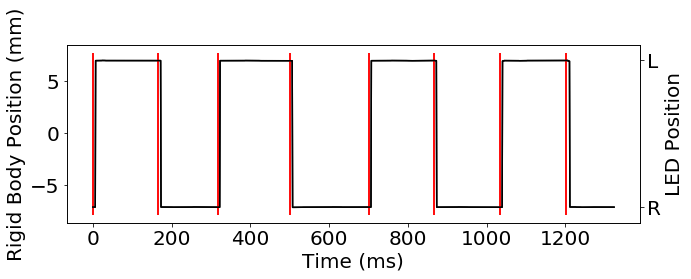

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
# vrl.analysis.plot_rb_position(dd['Time'], dd['RigidBody_Position_norm'], ax=ax);
ax.plot(dd['Time'], dd['RigidBody_Position_norm'] * 1000, color='k')
trial_init_time = dd.groupby('Trial').Time.apply(lambda x: x.min()).values
vrl.analysis.plot_trial_init(trial_init_time, ax=ax)
ax.set(xlabel='Time (ms)', ylabel='Rigid Body Position (mm)');

ax2 = ax.twinx()
ax2.plot(dd['Time'], dd['RigidBody_Position_norm'] * 1000, color='k')
trial_init_time = dd.groupby('Trial').Time.apply(lambda x: x.min()).values
vrl.analysis.plot_trial_init(trial_init_time, ax=ax2)
plt.yticks([dd['RigidBody_Position_norm'].min() * 1000, dd['RigidBody_Position_norm'].max() * 1000], ['R', 'L'])
ax2.set(ylabel='LED Position');
fig.tight_layout()

plt.savefig(figure_path + 'tracking_a' + '_session' + str(session_number) + '.png', transparent=False)

## Trials versus latency (with distribution)

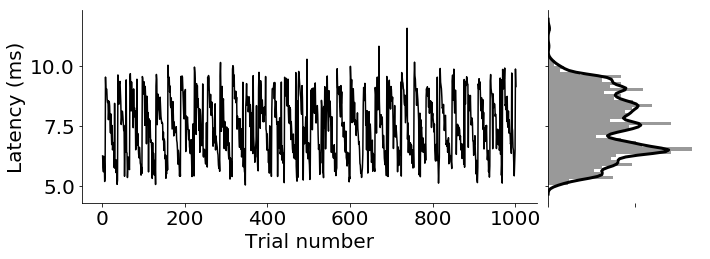

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
vrl.analysis.plot_tracking_latency_over_session(dfd_transformed.Trial, dfd_transformed.TrackingLatency, ax=ax1)
ax1.set(xlabel='Trial number', ylabel='Latency (ms)')
sns.despine(top=True, ax=ax1)

vrl.analysis.plot_tracking_latency_distribution(dfd_transformed['TrackingLatency'].values, ax=ax2)
sns.despine(top=True, bottom=True, ax=ax2)
ax2.set(xticklabels='')
fig.tight_layout(w_pad=0)

plt.savefig(figure_path + 'tracking_b' + '_session' + str(session_number) + '.png', transparent=False)

## Latency distribution alone

Enables comparison between different tracking latency measurements

In [13]:
latencies = dfd_transformed['TrackingLatency'].values

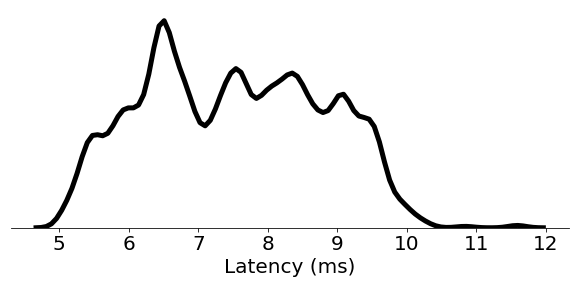

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(left=True)

data = latencies[np.isnan(latencies) == False]
sns.distplot(data, hist=False, color="k", kde_kws={"linewidth": 5, "alpha": 1}, ax=ax);
# ax.set(xlabel='Latency (ms)', ylabel='Frequency (normalized)');
ax.set(xlabel='Latency (ms)', ylabel='');
plt.yticks([]);

## Comparing multiple latency measurements data

tracking_20181003_192844.csv
tracking_20181003_193319.csv
tracking_20181005_165731.csv
tracking_20181005_171454.csv
tracking_20181005_171821.csv
tracking_20181005_172311.csv
tracking_20181005_173035.csv


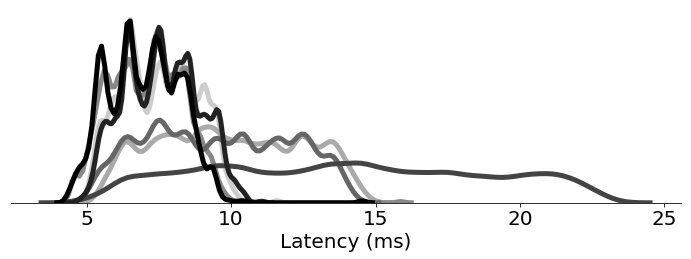

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.despine(left=True)

compare_these = filenames
gs_color = np.linspace(.8, 0, len(compare_these))

for ind, filename in enumerate(compare_these):
    print(filename)
    dfd = vrl.read_csv(filename)
    dfd_transformed = vrl.analysis.transform_tracking_df(dfd, session=session_name)
    latencies = dfd_transformed['TrackingLatency'].values
    data = latencies[np.isnan(latencies) == False]
    sns.distplot(data, color=str(gs_color[ind]), hist=False, kde_kws={"linewidth": 5, "alpha": 1}, ax=ax)
    
ax.set(xlabel='Latency (ms)', ylabel='')
plt.yticks([]);
fig.tight_layout()

plt.savefig(figure_path + 'tracking_c' + '_session' + str(session_number) + '.png', transparent=False)